In [1]:
%pylab inline
plt.style.use("bmh")

Populating the interactive namespace from numpy and matplotlib


In [3]:
import pathlib
import pandas as pd

from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [4]:
from tqdm import tqdm
tqdm.pandas()

C:\Users\gorba\anaconda3\lib\site-packages\tqdm\std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [5]:
RS = 7345

# Загрузка данных

In [6]:
DATA_DIR = pathlib.Path("C:/Users/gorba/DataSciense/Hackatons/SiburDigital")
# C:\Users\gorba\DataSciense\Hackatons\SiburDigital

In [7]:
train = pd.read_csv(DATA_DIR.joinpath("train.csv"), index_col="pair_id")
test = pd.read_csv(DATA_DIR.joinpath("test.csv"), index_col="pair_id")

In [20]:
train.head()

,name_1,name_2,is_duplicate
pair_id,,,
1,iko industries ltd.,"enormous industrial trade pvt., ltd.",0
2,apcotex industries ltd.,technocraft industries (india) ltd.,0
3,"rishichem distributors pvt., ltd.",dsa,0
4,powermax rubber factory,co. one,0
5,tress a/s,longyou industries park zhejiang,0


In [21]:
test.head()

,name_1,name_2
pair_id,,
1,sun blinds decoration inc.,indl de cuautitlan sa cv
2,eih ltd.,"dongguan wei shi plastic product co., ltd."
3,jsh ltd. (hk),arab shipbuilding and repair yard c
4,better industrial ltd.,farmacap industria e comercio ltda
5,equipos inoxidables del norte sa de cv,bel inc.


In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 497819 entries, 1 to 497819
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   name_1        497819 non-null  object
 1   name_2        497819 non-null  object
 2   is_duplicate  497819 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 15.2+ MB


In [11]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 213249 entries, 1 to 213249
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   name_1  213249 non-null  object
 1   name_2  213249 non-null  object
dtypes: object(2)
memory usage: 4.9+ MB


# Статистика таргета

In [12]:
train.is_duplicate.value_counts()

0    494161
1      3658
Name: is_duplicate, dtype: int64

In [13]:
train[train.is_duplicate==1].sample(15)

,name_1,name_2,is_duplicate
pair_id,,,
146402,Pirelli Neumaticos Argentina Sa,"Pirelli Tyre Co., Ltd.",1
224057,Dow Chemical Pacific Ltd.,"Dow Chemical (Shanghai) Co., Ltd.",1
242907,KILDAIR SERVICES,Kildair Service ULC,1
479355,Kumho Tire Changchun Co. Inc.,"Kumho Tire (Tianjin) Co., Ltd.",1
7583,Bridgestone India,"Bridgestone India Pvt., Ltd.",1
435353,SOPREMA BLONIE,SOPREMA GROBBENDONK,1
37957,Brenntag Mexico S.A. De C.V.,Brenntag Peru S.A.C.,1
69580,Pirelli Tire Llc,Pirelli Neumaticos S.A.I.C.,1
494598,Sumitomo Warehouse (Usa.) Inc.,Sumitomo Rubber Usa 10 Sheridan,1


In [14]:
train[train.is_duplicate==0].sample(15)

,name_1,name_2,is_duplicate
pair_id,,,
155450,Mrf Corporation,Dynasol Elastomeros Sa De Cv,0
275604,Topaz Multi Industries Sa,Sumitomo Rubber Industries Usa,0
75563,C.O.I.M. S.P.A. CHIMICA ORGANICA INDUSTRIALE M...,RAVAGO,0
91485,BITUMIX S.A.,Bolton Adhesives B.V.,0
456021,Jmd Imp. & Exp.,Sas Imp. S.A.C,0
468337,Smbm Comercia E Industria Textile,Ideal Industries,0
201978,Mti Llc,Tda Uruguay Limitada,0
371095,"Shenzhen Shantian Electric Appliance Co., Ltd.","Shenzhen Pintai Eletronics Co., Ltd.",0
167424,North West Rubber Ltd.,"Oriental Rubber Products Co., Ltd.",0


In [16]:
!pip install pycountry

  Created wheel for pycountry: filename=pycountry-20.7.3-py2.py3-none-any.whl size=10746867 sha256=e79a687582ec6c09a9c6afa2369c596ed143248b95672ff68bcbb8cf7b3b6e63
  Stored in directory: c:\users\gorba\appdata\local\pip\cache\wheels\57\e8\3f\120ccc1ff7541c108bc5d656e2a14c39da0d824653b62284c6
Successfully built pycountry


# Очистка данных

In [17]:
import pycountry
import re

In [18]:
countries = [country.name.lower() for country in pycountry.countries]

In [22]:
train["name_1"] = train["name_1"].str.lower()
train["name_2"] = train["name_2"].str.lower()

test["name_1"] = test["name_1"].str.lower()
test["name_2"] = test["name_2"].str.lower()

In [23]:
train[train.name_1.str.contains("gmbh")]

,name_1,name_2,is_duplicate
pair_id,,,
40,isoliererzeugnisse grobrohrsdorf gmbh,total rumunia,0
410,dortmunder gussasphalt gmbh & co. kg,bitoumina s.a.,0
440,celanese chemicals europe gmbh,inreco - emulsja sp. z o.o.,0
583,tremco illbruck group gmbh,wakol gmbh,0
681,rasco bitumentechnik gmbh,technpvinyl polymers india ltd.,0
...,...,...,...
497197,binne & sohn gmbh & co kg,buscher hoffmann,0
497306,mct gmbh & co. kg,valli zabban,0
497366,mct misch & compoundier technik gmbh,nknh,0


In [24]:
legal_entities = ["ltd.", "co.", "inc.", "b.v.", "s.c.r.l.", "gmbh", "pvt."]

for entity in tqdm(legal_entities):
    train.replace(re.compile(f"\s+{entity}\s*"), "", inplace=True)
    test.replace(re.compile(f"\s+{entity}\s*"), "", inplace=True)

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:29<00:00,  4.28s/it]


In [25]:
train.head()

,name_1,name_2,is_duplicate
pair_id,,,
1,iko industries,"enormous industrial trade,",0
2,apcotex industries,technocraft industries (india),0
3,"rishichem distributors,",dsa,0
4,powermax rubber factory,co. one,0
5,tress a/s,longyou industries park zhejiang,0


In [26]:
test.head()

,name_1,name_2
pair_id,,
1,sun blinds decoration,indl de cuautitlan sa cv
2,eih,"dongguan wei shi plastic product,"
3,jsh(hk),arab shipbuilding and repair yard c
4,better industrial,farmacap industria eercio
5,equipos inoxidables del norte sa de cv,bel


In [28]:
train.replace(re.compile(r"\s+\(.*\)"), "", inplace=True)
test.replace(re.compile(r"\s+\(.*\)"), "", inplace=True)

In [29]:
for country in tqdm(countries):
    train.replace(re.compile(country), "", inplace=True)
    test.replace(re.compile(country), "", inplace=True)

100%|████████████████████████████████████████████████████████████████████████████████| 249/249 [13:05<00:00,  3.16s/it]


In [30]:
train.replace(re.compile(r"[^\w\s]"), "", inplace=True)
test.replace(re.compile(r"[^\w\s]"), "", inplace=True)

In [31]:
train.sample(25)

,name_1,name_2,is_duplicate
pair_id,,,
473913,gknight sports goods pl,viv sports,0
445605,dsl,the salvation army employment,0
423629,sho international,shri arihant industries,0
100534,sc sports,jacc sports,0
261452,kbtrading,audi ag,0
420490,eia,protrade applied materialsp,0
35218,takara belmont p america do sul ind ede mov,r1 international,0
371124,durman esquivel sociedad anonima,serviam sociedad anonima,0
249099,maa enterprise,sankalp enterprises,0


In [32]:
test.sample(25)

,name_1,name_2
pair_id,,
60669,xigao industry,green ray medical equipment
53822,kinderpty,kerry logistics do brasil transportes inter
149508,indaco sp a,fundacion pablo wilches
85185,sho international,geleisihaimu plastic products
9097,colombo port of,taporation
54497,g bporation,arcor do brasil
4389,asahi kasei plastics,xeltic sa
101744,better industrial,shamini rubber industries
19083,sports facilitiespvt,sports and leisure apparel


# Простые метрики сходства строк

In [36]:
!pip install strsimpy


In [39]:
from strsimpy.levenshtein import Levenshtein
from strsimpy.normalized_levenshtein import NormalizedLevenshtein

In [41]:
levenshtein = Levenshtein()

train["levenstein"] = train.progress_apply(lambda r: levenshtein.distance(r.name_1, r.name_2), axis=1)
test["levenstein"] = test.progress_apply(lambda r: levenshtein.distance(r.name_1, r.name_2), axis=1)

  2%|█▍                                                                        | 9447/497819 [00:03<03:08, 2584.67it/s]

KeyboardInterrupt: 

In [42]:
train.head()

,name_1,name_2,is_duplicate,levenstein
pair_id,,,,
1,iko industries,enormous industrial trade,0,15.0
2,apcotex industries,technocraft industries,0,9.0
3,rishichem distributors,dsa,0,20.0
4,powermax rubber factory,co one,0,20.0
5,tress as,longyou industries park zhejiang,0,26.0


  2%|█▍                                                                        | 9478/497819 [00:19<03:08, 2584.67it/s]

In [43]:
normalized_levenshtein = NormalizedLevenshtein()

train["norm_levenstein"] = train.progress_apply(lambda r: normalized_levenshtein.distance(r.name_1, r.name_2),
                                                axis=1)
test["norm_levenstein"] = test.progress_apply(lambda r: normalized_levenshtein.distance(r.name_1, r.name_2),
                                              axis=1)


  3%|██▏                                                                      | 14840/497819 [00:06<03:33, 2258.19it/s]


  6%|████▍                                                                    | 30610/497819 [00:13<03:16, 2372.34it/s]


  9%|██████▊                                                                  | 46288/497819 [00:20<03:08, 2396.01it/s]


 13%|█████████▏                                                               | 62291/497819 [00:27<03:01, 2403.12it/s]


 16%|███████████▎                                                             | 77196/497819 [00:34<03:33, 1968.50it/s]


 19%|█████████████▋                                                           | 93516/497819 [00:41<02:48, 2399.82it/s]


 22%|███████████████▉                                                        | 110409/497819 [00:48<02:34, 2506.87it/s]


 26%|██████████████████▍                                                     | 127383/497819 [00:55<02:31, 2451.15it/s]


 29%|████████████████████▊                                                   | 144205/497819 [01:02<02:20, 2508.37it/s]


 32%|███████████████████████▏                                                | 160374/497819 [01:09<02:50, 1983.31it/s]


 35%|█████████████████████████▍                                              | 175914/497819 [01:16<02:26, 2203.56it/s]


 39%|███████████████████████████▉                                            | 192831/497819 [01:22<02:04, 2447.09it/s]


 42%|██████████████████████████████▎                                         | 209313/497819 [01:29<01:55, 2503.18it/s]


 45%|████████████████████████████████▋                                       | 225979/497819 [01:36<01:52, 2414.63it/s]


 49%|███████████████████████████████████                                     | 242676/497819 [01:43<01:44, 2437.95it/s]


 52%|█████████████████████████████████████▌                                  | 259452/497819 [01:50<01:33, 2552.79it/s]


 55%|███████████████████████████████████████▊                                | 275692/497819 [01:56<01:34, 2344.76it/s]


 58%|██████████████████████████████████████████                              | 291098/497819 [02:03<01:35, 2174.31it/s]


 62%|████████████████████████████████████████████▎                           | 306621/497819 [02:10<01:25, 2247.21it/s]


 65%|██████████████████████████████████████████████▌                         | 322105/497819 [02:17<01:19, 2213.29it/s]


 68%|████████████████████████████████████████████████▉                       | 338686/497819 [02:24<01:04, 2466.04it/s]


 71%|███████████████████████████████████████████████████▍                    | 355393/497819 [02:31<00:57, 2476.21it/s]


 75%|█████████████████████████████████████████████████████▊                  | 372231/497819 [02:37<00:51, 2453.15it/s]


 78%|████████████████████████████████████████████████████████▏               | 388870/497819 [02:44<00:44, 2437.32it/s]


 81%|██████████████████████████████████████████████████████████▋             | 405453/497819 [02:51<00:42, 2184.26it/s]


 85%|█████████████████████████████████████████████████████████████           | 422095/497819 [02:58<00:33, 2238.77it/s]


 88%|███████████████████████████████████████████████████████████████▎        | 437898/497819 [03:05<00:26, 2296.69it/s]


 91%|█████████████████████████████████████████████████████████████████▊      | 454742/497819 [03:12<00:17, 2510.66it/s]


 95%|████████████████████████████████████████████████████████████████████▏   | 471334/497819 [03:19<00:11, 2407.47it/s]


 98%|██████████████████████████████████████████████████████████████████████▌ | 487847/497819 [03:25<00:04, 2319.41it/s]


100%|████████████████████████████████████████████████████████████████████████| 497819/497819 [03:29<00:00, 2370.79it/s]

  3%|██▏                                                                       | 6432/213249 [00:02<01:27, 2354.47it/s]


 11%|███████▉                                                                 | 23269/213249 [00:09<01:16, 2477.73it/s]


 19%|█████████████▋                                                           | 39907/213249 [00:16<01:12, 2392.43it/s]


 27%|███████████████████▍                                                     | 56656/213249 [00:23<01:03, 2463.63it/s]


 34%|█████████████████████████▏                                               | 73475/213249 [00:29<00:56, 2473.98it/s]


 42%|██████████████████████████████▉                                          | 90321/213249 [00:36<00:49, 2502.99it/s]


 50%|████████████████████████████████████▏                                   | 107291/213249 [00:43<00:41, 2536.83it/s]


 58%|█████████████████████████████████████████▉                              | 124154/213249 [00:50<00:36, 2421.73it/s]


 66%|███████████████████████████████████████████████▌                        | 140896/213249 [00:57<00:28, 2553.11it/s]


 74%|█████████████████████████████████████████████████████▏                  | 157689/213249 [01:04<00:22, 2452.46it/s]


 82%|██████████████████████████████████████████████████████████▊             | 174353/213249 [01:10<00:16, 2383.30it/s]


 90%|████████████████████████████████████████████████████████████████▌       | 191124/213249 [01:17<00:08, 2458.96it/s]


 97%|██████████████████████████████████████████████████████████████████████  | 207661/213249 [01:24<00:02, 2111.71it/s]


100%|████████████████████████████████████████████████████████████████████████| 213249/213249 [01:27<00:00, 2444.55it/s]


In [44]:
train.head()

,name_1,name_2,is_duplicate,levenstein,norm_levenstein
pair_id,,,,,
1,iko industries,enormous industrial trade,0,15.0,0.600000
2,apcotex industries,technocraft industries,0,9.0,0.409091
3,rishichem distributors,dsa,0,20.0,0.909091
4,powermax rubber factory,co one,0,20.0,0.869565
5,tress as,longyou industries park zhejiang,0,26.0,0.812500


In [45]:
test.head()

,name_1,name_2,levenstein,norm_levenstein
pair_id,,,,
1,sun blinds decoration,indl de cuautitlan sa cv,20.0,0.833333
2,eih,dongguan wei shi plastic product,29.0,0.906250
3,jshhk,arab shipbuilding and repair yard c,33.0,0.942857
4,better industrial,farmacap industria eercio,15.0,0.600000
5,equipos inoxidables del norte sa de cv,bel,35.0,0.921053


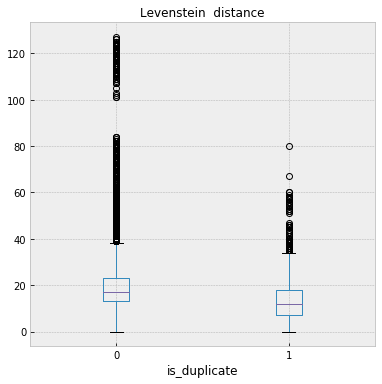

In [46]:
plt.figure(figsize=(6,6))

train.boxplot("levenstein", by="is_duplicate", ax=plt.gca())
plt.suptitle("")
plt.title("Levenstein  distance", fontsize=12);

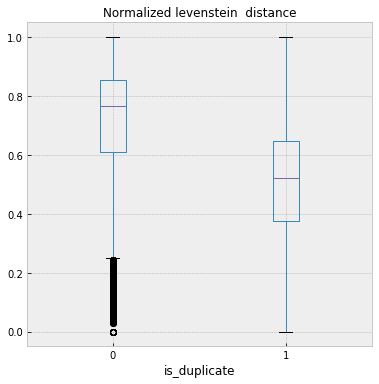

In [47]:
plt.figure(figsize=(6,6))

train.boxplot("norm_levenstein", by="is_duplicate", ax=plt.gca())
plt.suptitle("")
plt.title("Normalized levenstein  distance", fontsize=12);

# Базовая модель

In [48]:
FTS = ["levenstein", "norm_levenstein"]
THR = 0.9

In [49]:
split = StratifiedShuffleSplit(1, train_size=0.8, random_state=RS)
tridx, cvidx = list(split.split(train[FTS], train["is_duplicate"]))[0]

In [50]:
model = LogisticRegression(class_weight="balanced")
model.fit(train.iloc[tridx][FTS].values,
          train.iloc[tridx]["is_duplicate"].values)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [51]:
tr_preds = model.predict_proba(train.iloc[tridx][FTS].values)
cv_preds = model.predict_proba(train.iloc[cvidx][FTS].values)

In [52]:
tr_preds = (tr_preds[:, 1] > THR).astype(np.int)
cv_preds = (cv_preds[:, 1] > THR).astype(np.int)

In [53]:
print(classification_report(train.iloc[tridx]["is_duplicate"].values, tr_preds))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99    395329
           1       0.17      0.13      0.15      2926

    accuracy                           0.99    398255
   macro avg       0.58      0.56      0.57    398255
weighted avg       0.99      0.99      0.99    398255



In [54]:
print(classification_report(train.iloc[cvidx]["is_duplicate"].values, cv_preds))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     98832
           1       0.17      0.14      0.15       732

    accuracy                           0.99     99564
   macro avg       0.58      0.57      0.57     99564
weighted avg       0.99      0.99      0.99     99564



In [55]:
print(f1_score(train.iloc[tridx]["is_duplicate"].values, tr_preds))
print(f1_score(train.iloc[cvidx]["is_duplicate"].values, cv_preds))

0.14792338327327895
0.15128593040847202


# Генерация сабмита

In [58]:
sample_sub = pd.read_csv(DATA_DIR.joinpath("baseline_submission.csv"), index_col="pair_id")

In [59]:
sample_sub

,is_duplicate
pair_id,
1,0
2,0
3,0
4,0
5,0
...,...
213245,0
213246,0
213247,0


In [60]:
sample_sub["is_duplicate"] = (model.predict_proba(test[FTS].values)[:, 1] > THR).astype(np.int)

In [61]:
sample_sub.is_duplicate.value_counts()

0    211968
1      1281
Name: is_duplicate, dtype: int64

In [62]:
sample_sub.to_csv(DATA_DIR.joinpath("baseline_submission.csv"))